# Predicting African Government Debt Interest Rates

In [1]:
# !pip install openpyxl
import copy
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import pearsonr

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import KFold
from sklearn.base import BaseEstimator
from sklearn.preprocessing import PolynomialFeatures

import torch
import torch.nn as nn
import torch.optim as optim

torch.set_default_dtype(torch.float)

import warnings

## Story

Context (fictional):

As a data scientist working for a international financial institution called Global Economic Analytics (GEA), I am assigned to a critical project aimed at improving our understanding of African government debt and enhancing our ability to predict interest rates. GEA's mission is to provide data-driven insights and analysis to support informed economic decision-making, and this project aligns perfectly with our objectives.

Recent experiences have highlighted the centrality of debt transparency both to avoid defaults and effectively resolving renegotiations. Mozambique's recent default, for example, came after large amounts of previously hidden debt became public knowledge. In Zambia, a key stumbling block during debt renegotiations with private creditors is the role of Chinese debts, in particular the lack of transparency on lending volumes and
interest payments.There is a growing international recognition that better, more granular debt data is needed in developing countries. In recent years, African countries have witnessed significant economic growth and development. However, managing government debt has become increasingly complex due to diverse sources of funding, differing debt structures, and varying interest rates. To aid policy-makers, investors, and international organizations, GEA recognizes the need to create a robust predictive model for African government debt interest rates.

Project Task:

The task of this project is to develop a regression neural network model to predict interest rates on loans and bonds issued by African governments. By leveraging a comprehensive dataset covering over 7,493 loans and bonds between 2000 and 2020, we aim to create a tool that forecasts interest rates, which will help in a situation of insufficient public information enable proactive decision-making and risk management in the African debt market.

Experiment Plan:

1) Dataset Acquisition and Preparation: Gather the dataset from reliable open sources, ensuring completeness and data quality.
Perform data cleaning. Convert categorical variables into numerical representations for model compatibility.
2) Feature Selection and Engineering: Conduct a thorough analysis of the dataset to identify the most relevant features for predicting interest rates. Convert categorical variables (such as CreditorGroup) into numerical representations using techniques like one-hot encoding. Remove rare features.
3) Model Architecture and Training: Use a simple baseline (Mean, Linear Regression). Develop regression neural networks with different architectures (number and types of layers, parameters). Define criterion and optimizer. Train the models using the training set and optimize hyperparameters to maximize performance.
4) Model Evaluation and Validation: Calculate evaluation metrics such as MSE, MAE, MAPE. Compare the NN results with baselines and between each over. Fine-tune the models.


Purpose and Value:

The primary objective of this experiment is to create a regression neural network model that predicts interest rates on African government loans and bonds. By achieving this goal, we aim to provide GEA's stakeholders with a tool that enhances their understanding of African debt markets. The model's predictions will enable policy-makers to make proactive decisions, investors to assess risk, and international organizations to develop targeted strategies for supporting economic development in African countries.

Through this project, GEA aims to contribute to the economic growth and stability of African nations by providing data-driven insights and empowering decision-makers in their debt management efforts.

## The Data

Dataset Source: https://www.ifw-kiel.de/publications/kiel-working-papers/2022/who-lends-to-africa-and-how-introducing-the-africa-debt-database-17146/

Authors of the dataset: David Mihalyi and Christoph Trebesch from Kiel Institute for the World Economy. I asked one of the authors (Christoph Trebesch) by email about the possible restrictions to use the dataset and received an answer that the data is public and free to use for all.

About the dataset: Dataset covers over 7493 loans and bonds taken and issued by African countries (all 54 out of the 54 countries on the continent) between 2000 and 2020, with a total volume of 790 billion USD. The dataset is gathered instrument-by-instrument, so each loan or bond is a single record. Dataset focuses on external debt by central governments. External debt is defined by currency, governing law, and place of issuance, with an emphasis on currency. African government debt in hard currency is thus generally part of this data collection, as are sovereign bonds placed in New York or London or loans extended by Chinese state-owned banks. 

The following list describes the selection criteria for the dataset:
- Domestic government debt, in particular local currency bonds, even if they are held or issued abroad, excluded.
- Government-to-government loans, including those extended by China’s state-owned companies included.
- Debt raised by public corporations and debt that is publicly guaranteed excluded.
- Short term debt instruments are excluded (focusing on external public bonds and loans with maturities of a year or more).
- Focusing on sovereign bonds only. The dataset does not cover bank loans or loans by commodity traders.
- Focusing on loans and bonds, grants are excluded.
- Loans where the recipient was a regional organization were excluded

Sources of the information about loans: Official loans reported to OECD (3491 loans), World Bank lending (2470 loans), Chinese lenders (1149 loans), IMF lending (187 loans), USA bilateral lending (42 loans), External bonds (154 bonds).

17 variables in the African Debt Dataset:

Borrower info:
* Country - Name of the borrowing country
* Iso3c - iso3c code of the borrowing country
* BorrowerType  - Type of borrowing entity: Central government/JV=Joint Venture/SOE=State-owned enterprise
* BorrowerAgency - Name of borrower agency

Creditor info:
* CreditorName - Name of creditor country if bilateral loan, name of creditor institution if multilateral loan, Bondholders if sovereign bond
* CreditorName_short - Abbreviations for multilateral institutions, short creditor country names.
* CreditorGroup - Bilateral/multilateral/private. Chinese loans are considered as bilateral, if the creditor is the central government or another government agency or a state-owned policy bank. Chinese SOE and state-owned commercial bank loans are considered as private.
* CreditorAgency - Name of the lending agency (E.g., ministries, bank names, SOE names, multilateral creditor agency names, etc.)
* CreditorAgencyType  - Type of lending agency, if available. (E.g., central government, SOE, multilateral development bank, etc.)

Basic information:
* Year - Year of loan commitment or bond issuance.
* Quarter - Quarter of the year in which commitment was made (bond issued). Possible values: Q1, Q2, Q3, Q4.
* Amount_musd  - Commitment amount in the case of loans, original amount issued in case of bonds. When bonds are re-opened,the reopening amounts are not considered. All are measured in million USD and were converted using market exchange rates

Financial terms:
* Interest - Interest rate of loan. All floating rates were transformed into a fixed rate equivalent using the following method:average reference rate of the commitment year + margin.
* Structure - Type of interest rate in the case of OECD loans: fix or floating (variable). Repayment structure in case of bonds: sinking fund or bullet (or unknown). Type of facility in case of IMF loans. All bonds have fixed interest rates
* Maturity - Number of years between issuance date and the date when the principal on the loan or bond is due (last tranche).
* Grace - Number of years between commitment date and the date of the first installment. 

Data source used:
* Source - Short citation of the source of the loan terms.

Due to the fact that the collection of data on the debt of African countries is not systematized, as well as the lack of transparency in the reporting of these countries, this dataset is collected from open sources and is incomplete.

## Initial Data Analysis

Open the excel file with the database already downloaded from the link: https://www.ifw-kiel.de/fileadmin/Dateiverwaltung/IfW-Publications/-ifw/Kiel_Working_Paper/2022/KWP_2217_Who_Lends_to_Africa_and_How_/Africa_Debt_Database_2023_NEU.xlsx

In [2]:
data = pd.read_excel('data/Africa_Debt_Database_2023_NEU.xlsx', sheet_name='Database')

In [3]:
data.head()

,country,iso3c,BorrowerType,BorrowerAgency,CreditorName,CreditorName_short,CreditorGroup,CreditorAgency,CreditorAgencyType,year,quarter,Amount_musd,interest,structure,maturity,grace,source
0,Algeria,DZA,NaN,Government of Algeria,World Bank (IBRD),WB-IBRD,Multilateral,IBRD,Multilateral development bank,2000,Q3,83,NaN,FSL,16.000000,2.750000,World Bank
1,Algeria,DZA,NaN,NaN,African Development Bank,AfDB,Multilateral,AfDB Ordinary Capital,NaN,2000,Q4,117,NaN,NaN,20.000000,5.000000,OECD
2,Algeria,DZA,NaN,NaN,Islamic Development Bank,IsDB,Multilateral,Islamic Development Bank,NaN,2000,Q4,87,NaN,NaN,NaN,NaN,OECD
3,Algeria,DZA,NaN,Government of Algeria,World Bank (IBRD),WB-IBRD,Multilateral,IBRD,Multilateral development bank,2000,Q4,5,NaN,FSL,13.480769,3.692308,World Bank
4,Algeria,DZA,NaN,Government of Algeria,World Bank (IBRD),WB-IBRD,Multilateral,IBRD,Multilateral development bank,2000,Q4,9,NaN,FSL,14.000000,3.711539,World Bank


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7493 entries, 0 to 7492
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country             7493 non-null   object 
 1   iso3c               7493 non-null   object 
 2   BorrowerType        1405 non-null   object 
 3   BorrowerAgency      5298 non-null   object 
 4   CreditorName        7493 non-null   object 
 5   CreditorName_short  7493 non-null   object 
 6   CreditorGroup       7493 non-null   object 
 7   CreditorAgency      7493 non-null   object 
 8   CreditorAgencyType  3769 non-null   object 
 9   year                7493 non-null   int64  
 10  quarter             6147 non-null   object 
 11  Amount_musd         7493 non-null   int64  
 12  interest            5602 non-null   float64
 13  structure           2887 non-null   object 
 14  maturity            5620 non-null   float64
 15  grace               5411 non-null   float64
 16  source

There are 7493 rows with credit entries for each and 17 columns with features (one of the columns is a target - the 'interest'). Most of the columns contain categorical data (object dtype) and also some of the data is missing

Statisctics for the numerical data:

In [5]:
data.describe()

,year,Amount_musd,interest,maturity,grace
count,7493.000000,7493.000000,5602.000000,5620.000000,5411.000000
mean,2011.757374,105.477112,1.403177,25.431677,7.812739
std,6.005747,278.032840,1.584041,10.371935,3.839673
min,2000.000000,0.000000,0.000000,0.000000,0.000000
25%,2007.000000,13.000000,0.800000,19.500000,5.000000
50%,2013.000000,34.000000,0.800000,29.000000,7.000000
75%,2017.000000,90.000000,2.000000,30.000000,10.000000
max,2020.000000,6900.000000,12.300000,62.000000,55.000000


Year, Amount of the loans, Interest rates, Maturity and Grace periods are numerical features. Some of the data is missing for interest rates. Also the mininmum of 0 for Amount, interest and maturity is most likely a mistake (or lack of relevant information) because it makes no sense

Statisctics for the categorical data:

In [6]:
data.describe(include=[object])

,country,iso3c,BorrowerType,BorrowerAgency,CreditorName,CreditorName_short,CreditorGroup,CreditorAgency,CreditorAgencyType,quarter,structure,source
count,7493,7493,1405,5298,7493,7493,7493,7493,3769,6147,2887,7493
unique,54,54,27,377,34,33,3,113,12,4,10,7
top,Morocco,MAR,Central government,Government of Angola,World Bank (IDA),WB-IDA,Multilateral,IDA,Multilateral development bank,Q4,Fixed,OECD
freq,350,350,1087,218,2262,2262,4583,2262,2470,2247,2086,3491


Also there are some missing data. Also for some columns there are a large number of unique values.

We can look at the mean distribution of loans amounts, interest rates and maturity for different creditor groups

In [7]:
data[['CreditorGroup', 'interest', 'Amount_musd', 'maturity']].groupby('CreditorGroup').mean().sort_values(by='interest', ascending=False).reset_index()

,CreditorGroup,interest,Amount_musd,maturity
0,Private,3.605263,384.315789,14.686933
1,Bilateral,1.870645,92.155647,23.086475
2,Multilateral,0.921194,83.655029,27.996420


Private investors have the largest size of the mean loan amount, the shortest mean maturity perid and the largest mean interest rate.

Distribution of debt among investors:

In [8]:
data[['CreditorName', 'CreditorGroup', 'Amount_musd',]].groupby(['CreditorName', 'CreditorGroup']).sum().sort_values(by='Amount_musd', ascending=False).reset_index().head(10)

,CreditorName,CreditorGroup,Amount_musd
0,Bondholders,Private,146343
1,World Bank (IDA),Multilateral,145683
2,China,Bilateral,143739
3,International Monetary Fund,Multilateral,76544
4,African Development Bank,Multilateral,45663
5,China private,Private,36207
6,Islamic Development Bank,Multilateral,33117
7,France,Bilateral,30769
8,World Bank (IBRD),Multilateral,28382
9,African Development Fund,Multilateral,20695


Private bondholders, World Bank loans and credits from China are major investors

On the other hand, we can look at the countries that are the most active borrowers. Top 5 countries with the largest amount of debt:

In [9]:
data[['country', 'Amount_musd']].groupby('country').sum().sort_values(by='Amount_musd', ascending=False).reset_index().head(5)

,country,Amount_musd
0,Egypt,74197
1,Morocco,73445
2,Angola,63768
3,South Africa,56135
4,Nigeria,52531


Top 5 countries with the highest mean interest rates:

In [10]:
data[['country', 'interest']].groupby('country').mean().sort_values(by='interest', ascending=False).reset_index().head(5)

,country,interest
0,South Africa,4.666337
1,Angola,3.635606
2,Botswana,3.041176
3,Seychelles,2.935714
4,Equatorial Guinea,2.866667


PLotting mean debt interest rates for each African country:

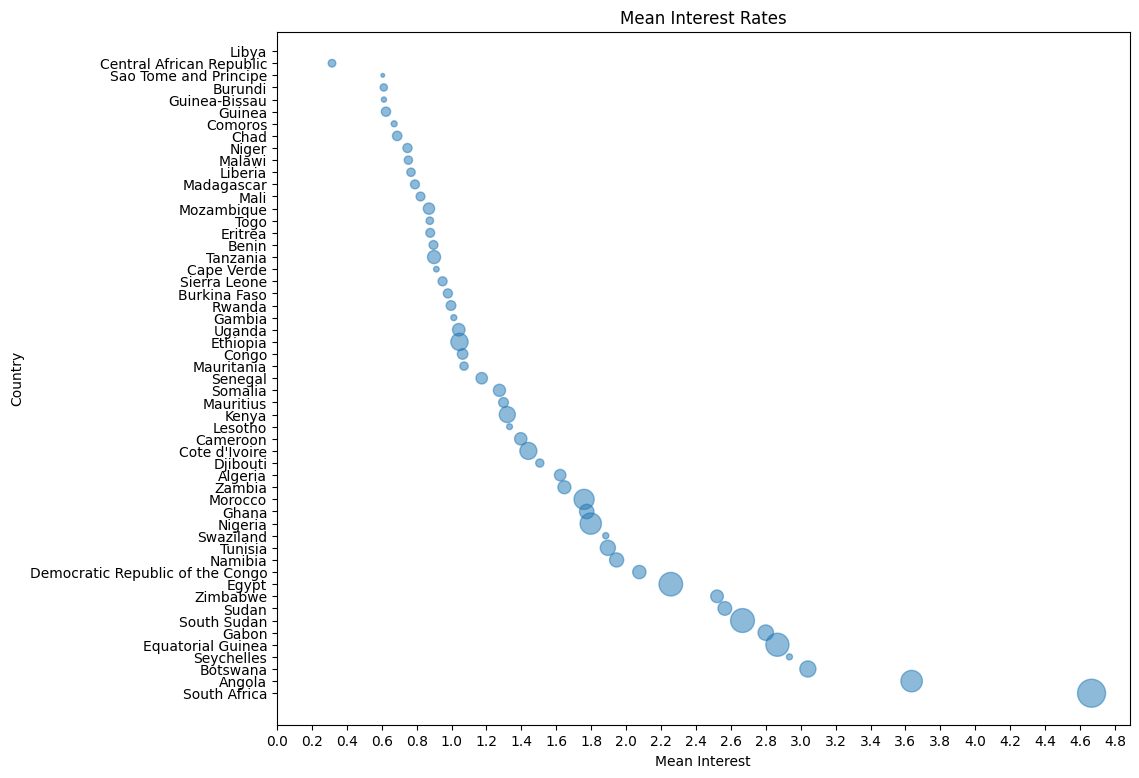

In [11]:
countries = data[['country', 'interest', 'Amount_musd']].groupby('country').mean().sort_values(by='interest', ascending=False).reset_index()
x = countries['interest']
y = range(len(countries))
radius = countries['Amount_musd']
labels = countries['country']

fig, ax = plt.subplots(figsize=(11, 9))

circles = ax.scatter(x, y, s=radius, alpha=0.5)
ax.set_yticks(y)
ax.set_yticklabels(labels)
xticks = np.arange(0,5,0.2) 
ax.set_xticks(xticks)
ax.set_xlabel('Mean Interest')
ax.set_ylabel('Country')
ax.set_title('Mean Interest Rates')

plt.show()

## Data Preprocessing

Firstly we can drop the redundant ('iso3c') and useless in research columns. We do not need additional info about borrowers ('BorrowerType', 'BorrowerAgency'), just the name of the country will be enough. We are not interested in 'CreditorName', 'CreditorAgency', 'CreditorAgencyType' columns because some info is missing.

In [12]:
df = data.drop(columns=['iso3c', 'BorrowerType', 'BorrowerAgency', 'CreditorName', 'CreditorAgency', 'CreditorAgencyType', 'quarter', 'structure', 'source'])
df.head()

,country,CreditorName_short,CreditorGroup,year,Amount_musd,interest,maturity,grace
0,Algeria,WB-IBRD,Multilateral,2000,83,NaN,16.000000,2.750000
1,Algeria,AfDB,Multilateral,2000,117,NaN,20.000000,5.000000
2,Algeria,IsDB,Multilateral,2000,87,NaN,NaN,NaN
3,Algeria,WB-IBRD,Multilateral,2000,5,NaN,13.480769,3.692308
4,Algeria,WB-IBRD,Multilateral,2000,9,NaN,14.000000,3.711539


Additionally delete missing information:

In [13]:
df=df.dropna(axis=0)

Delete rows where the interest rate is zero to avoid dividing by zero in the future:

In [14]:
df = df[df['interest'] != 0]

We do not have the task of analyzing data over time, so let's apply the category datatype to the "year" column:

In [15]:
df['year']=df['year'].astype(object)

In [16]:
df.describe()

,Amount_musd,interest,maturity,grace
count,4317.000000,4317.000000,4317.000000,4317.000000
mean,106.207320,1.530762,26.303461,7.733693
std,264.166543,1.456440,9.729305,3.536621
min,0.000000,0.100000,0.000000,0.000000
25%,14.000000,0.800000,20.000000,5.000000
50%,35.000000,0.800000,29.500000,7.000000
75%,88.000000,2.000000,30.019178,9.980769
max,5156.000000,12.300000,53.000000,40.027397


Now we have 4317 rows of with 4 columns of non-missing numerical features, with not-zero interest rates data

In [17]:
df.describe(include='object')

,country,CreditorName_short,CreditorGroup,year
count,4317,4317,4317,4317
unique,53,25,3,21
top,Kenya,WB-IDA,Multilateral,2017
freq,230,1837,2697,303


Also 4317 rows of non-missing categorical data with 4 features

In [18]:
df.head()

,country,CreditorName_short,CreditorGroup,year,Amount_musd,interest,maturity,grace
5,Algeria,Belgium,Bilateral,2001,4,2.0,28.0,9.0
12,Algeria,France,Bilateral,2002,5,0.4,31.0,11.0
13,Algeria,Italy,Bilateral,2002,27,1.0,25.0,10.0
16,Algeria,Spain,Bilateral,2002,62,1.5,20.0,9.0
21,Algeria,France,Bilateral,2003,45,3.5,10.0,4.0


Distribution of Creditors by the name:

In [19]:
df['CreditorName_short'].value_counts(normalize=True).head(5)

WB-IDA     0.425527
France     0.107482
AfDB       0.090572
China      0.085476
Germany    0.048413
Name: CreditorName_short, dtype: float64

In [20]:
df['CreditorName_short'].unique()

array(['Belgium', 'France', 'Italy', 'Spain', 'IFAD', 'UAE', 'WB-IDA',
       'China', 'Portugal', 'China private', 'Korea', 'AfDB', 'IMF',
       'Bondholders', 'OPEC Fund', 'Kuwait', 'Japan', 'BADEA',
       'Saudi Arabia', 'Germany', 'WB-IBRD', 'AFESD', 'United States',
       'Poland', 'Sweden'], dtype=object)

We can remove rare creditor names categories into the 'Other' value:

In [21]:
df['CreditorName_New'] = df['CreditorName_short'].mask(df['CreditorName_short'].map(df['CreditorName_short'].value_counts(normalize=True)) < 0.01, 'Other')
df=df.drop('CreditorName_short', axis=1)

Also the same could be done with the borrower's country names: rare countries will be groupped inside the 'Other' category

In [22]:
df['country_new'] = df['country'].mask(df['country'].map(df['country'].value_counts(normalize=True)) < 0.01, 'Other')
df=df.drop('country', axis=1)

In [23]:
df.describe(include='object')

,CreditorGroup,year,CreditorName_New,country_new
count,4317,4317,4317,4317
unique,3,21,15,34
top,Multilateral,2017,WB-IDA,Other
freq,2697,303,1837,393


In [24]:
print(df.shape)
df.head(5)

(4317, 8)


,CreditorGroup,year,Amount_musd,interest,maturity,grace,CreditorName_New,country_new
5,Bilateral,2001,4,2.0,28.0,9.0,Other,Other
12,Bilateral,2002,5,0.4,31.0,11.0,France,Other
13,Bilateral,2002,27,1.0,25.0,10.0,Other,Other
16,Bilateral,2002,62,1.5,20.0,9.0,Spain,Other
21,Bilateral,2003,45,3.5,10.0,4.0,France,Other


We have 4317 rows of instances, 7 columns of features and 1 target column

## Setup ML Experiment

The goal is to predict the interest rates for African countries loans based on features

Remove target column 'interest' from the dataset and create 'target' variable:

In [25]:
target = df.loc[:, ["interest"]]
data = df.drop("interest", axis=1)

We will convert categorical variables into a numerical representation by using "pd.get_dummies()" function. It creates a new DataFrame with binary columns for each unique value in the categorical variable. Each column represents one unique value, and the values in the column are either 0 or 1, indicating the absence or presence of that value in the original variable. By creating these binary columns, we preserve the information about the categories while enabling the machine learning algorithm to operate on the data - one-hot encoding.

In [26]:
warnings.filterwarnings('ignore') #Ignoring warnings
df_dummified=pd.get_dummies(data, drop_first=True)
print(df_dummified.shape)
df_dummified.head(5)
warnings.filterwarnings('default') #Returning warnings

(4317, 72)


"drop_first=True" parameter is set to True, indicating that the function should drop the first category for each categorical variable. By default, pd.get_dummies() creates dummy variables for all unique values in a categorical variable. Dropping the first category helps avoid ulticollinearity, a situation where one category can be predicted perfectly from the others.

In [27]:
df_dummified.describe()

,Amount_musd,maturity,grace,CreditorGroup_Multilateral,CreditorGroup_Private,year_2001,year_2002,year_2003,year_2004,year_2005,...,country_new_Other,country_new_Rwanda,country_new_Senegal,country_new_Sierra Leone,country_new_South Africa,country_new_Sudan,country_new_Tanzania,country_new_Tunisia,country_new_Uganda,country_new_Zambia
count,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,...,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000
mean,106.207320,26.303461,7.733693,0.624739,0.042854,0.044244,0.035905,0.031735,0.023859,0.037063,...,0.091035,0.023396,0.045634,0.017373,0.016215,0.010656,0.044939,0.042159,0.032198,0.026407
std,264.166543,9.729305,3.536621,0.484246,0.202551,0.205660,0.186074,0.175314,0.152628,0.188938,...,0.287693,0.151175,0.208713,0.130673,0.126316,0.102686,0.207193,0.200975,0.176547,0.160362
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,14.000000,20.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,35.000000,29.500000,7.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,88.000000,30.019178,9.980769,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5156.000000,53.000000,40.027397,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [28]:
df_dummified.shape

(4317, 72)

After dummification we have 52 columns with features

Now we can explore correlation between target value ('interest') and each feature:

In [29]:
correlation_df = pd.DataFrame(columns=['Column', 'Correlation', 'p-value'])

for c in range(df_dummified.shape[1]):
    correlation, p_value = pearsonr(target.squeeze(), df_dummified.iloc[:, c])
    correlation_df.loc[c] = [df_dummified.columns[c], correlation, p_value]

positive = correlation_df.sort_values(by='Correlation', ascending=False).head(5)
negative = correlation_df.sort_values(by='Correlation', ascending=True).head(5)

Top 5 positive correlations:

In [30]:
print(positive)

                          Column  Correlation        p-value
4          CreditorGroup_Private     0.614112   0.000000e+00
25  CreditorName_New_Bondholders     0.583253   0.000000e+00
0                    Amount_musd     0.390758  1.741215e-157
26        CreditorName_New_China     0.273112   1.029201e-74
66      country_new_South Africa     0.209499   5.093534e-44


We can see positive correlation between interest rates and Private creditors group and Bondholders creditor's name (p-value are small, which means it is not just a coincidence), also with large loan amount correlate with larger interest rates. We have already seen these patterns

Top 5 negative correlations:

In [31]:
print(negative)

                        Column  Correlation        p-value
3   CreditorGroup_Multilateral    -0.477917  2.802366e-245
1                     maturity    -0.469734  6.679156e-236
38     CreditorName_New_WB-IDA    -0.351192  1.587910e-125
2                        grace    -0.102147   1.730471e-11
31        CreditorName_New_IMF    -0.089261   4.232657e-09


For multirateral creditor groups, World Bank loans (WB-IDA) and longer maturity the interest rates are lower

The plot shows the correlation between maturity and interest rates:

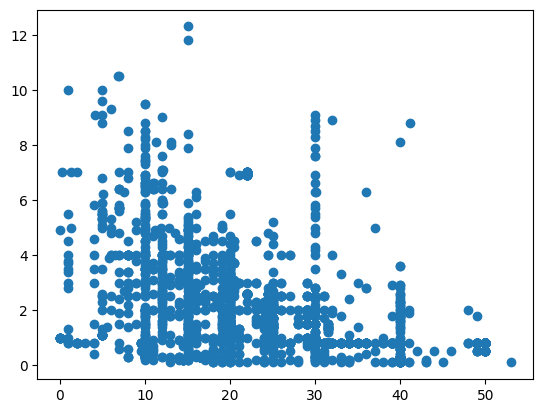

In [32]:
plt.scatter(df_dummified.maturity, target)

There is a negative correlation between maturity of the loans and target interest rates: longe the loan lower the interest rates. Pearson correlation coefficient between maturity and interests is -0.47, with pvalue=6.67e-236 (lower than 0.05).

### Split dataset into Test and Training Data

Split the dataset into the train (60%) and test (40%):

In [33]:
X_train, X_test, y_train, y_test = train_test_split(df_dummified, target, test_size=0.4, shuffle=True, random_state=42)

In [34]:
for i in (X_train, X_test, y_train, y_test):
    print(i.shape)

(2590, 72)
(1727, 72)
(2590, 1)
(1727, 1)


Scale the data

Scaling is important because the features are multiplied by the model weights. So, the scale of the outputs and the scale of the gradients are affected by the scale of the inputs. Although a model might converge without feature normalization, normalization makes training much more stable.

In [35]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

In [36]:
X_train_sc = x_scaler.fit_transform(X_train)
X_test_sc = x_scaler.transform(X_test)
y_train_sc=y_scaler.fit_transform(y_train)
y_test_sc=y_scaler.transform(y_test)

Create Tensors for PyTorch

In [37]:
X_train_tensor=torch.Tensor(X_train_sc)
X_test_tensor=torch.Tensor(X_test_sc)
y_train_tensor=torch.Tensor(y_train_sc)
y_test_tensor=torch.Tensor(y_test_sc)

## Creating Evaluation metrics and Baselines

For regression problems, we never expect the model to predict the values perfectly. Therefore, you need to care about how close the prediction is to the actual value. The loss metrics that can be used for this are the mean square error (MSE), mean absolute error (MAE), mean absolute percentage error (MAPE).
* **Mean absolute error (MAE)** - the mean difference between each of the predictions.
* **Mean squared error (MSE)** - the squared mean difference between of the predictions (use if larger errors are more detrimental than smaller errors).
* **Mean absolute percentage error (MAPE)** - the most common measure used to forecast error, probably because the variable’s units are scaled to percentage units, which makes it easier to understand.

The lower each of these values, the better.

In [38]:
results = pd.DataFrame()

def add_eval(results, algorithm, y_train, y_train_pred, y_test, y_test_pred):
    for dataset, actual, predicted in zip(("train", "test"), (y_train, y_test), (y_train_pred, y_test_pred)):
        results= pd.concat([results, pd.DataFrame([{
            "algorithm": algorithm, 
            "dataset": dataset,
            "MSE": round(mean_squared_error(actual, predicted),5),
            "MAE": round(mean_squared_error(actual, predicted, squared=False),5),
            "MAPE": round(mean_absolute_percentage_error(actual, predicted),5)
        }])], ignore_index=True)   
    return results

### Mean

A regular mean is the first baseline measure

In [39]:
y_train_mean=y_train.interest.mean()
y_test_mean=y_test.interest.mean()

y_train_const=np.ones_like(y_train)* y_train_mean
y_test_const=np.ones_like(y_test)* y_test_mean

results = add_eval(results, "Mean_baseline", y_train, y_train_const, y_test, y_test_const)

### Linear Regression

For the baseline we will use ordinary least squares Linear Regression. LinearRegression fits a linear model with coefficients  to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation.

In [40]:
clf = LinearRegression()
clf.fit(X_train_sc, y_train_sc)
y_train_lin_pred=y_scaler.inverse_transform(clf.predict(X_train_sc))
y_test_lin_pred=y_scaler.inverse_transform(clf.predict(X_test_sc))
results = add_eval(results, "LR_baseline", y_train, y_train_lin_pred, y_test, y_test_lin_pred)

Linear Regression stores the coefficients of the linear model in its coef_ member:

In [41]:
print(clf.coef_.shape)

(1, 72)


In total 52 coefficients, each for every feature

R2 (coefficient of determination) regression score function. An R2 of 1.0 indicates that the data perfectly fit the linear model. Any R2 value less than 1.0 indicates that at least some variability in the data cannot be accounted for by the model (e.g., an R2 of 0.60 indicates that 40% of the variability in the outcome data cannot be explained by the model). 

Generally, an R-Squared above 0.6 makes a model worth your attention. If we wish to label the strength of the association, for absolute values of r, 0-0.19 is regarded as very weak, 0.2-0.39 as weak, 0.40-0.59 as moderate, 0.6-0.79 as strong and 0.8-1 as very strong correlation, but these are rather arbitrary limits, and the context of the results should be considered.

In [42]:
r2_score(y_test, y_test_lin_pred)

0.6126011258164987

R2 score of 0.61 means a strong correlation

In [43]:
results

,algorithm,dataset,MSE,MAE,MAPE
0,Mean_baseline,train,2.24988,1.49996,1.07217
1,Mean_baseline,test,1.92293,1.38670,0.94593
2,LR_baseline,train,0.78620,0.88668,0.60351
3,LR_baseline,test,0.74494,0.86310,0.57113


We created metrics and baseline 'models' to evaluate neural networks

## Deep Learning Experiments

We will conduct DL experiments with following neural network architectures:

* SimpleNet. The simplest model consists just of linear layers
* Multi-Layer Perceptrons (MLPs) also known as Feedforward Neural Networks (FNNs). MLPs consist of an input layer, one or more hidden layers, and an output layer. MLPs can be used for regression tasks by adjusting the activation function in the output layer.
* MLP with Dropout layer - to the previous model we will add one dropout layer, to reduce overfitting

We will perform some experiments in order to find the optimal value of the parameter for the dropout layer.

And in order to reduce the influence of randomness factor we will conduct an experiment with cross validation

### SimpleNet model

Let’s try the traditional design of a neural network - the pyramid structure. A pyramid structure is to have the number of neurons in each layer decreasing as the network progresses to the output. The number of input features is fixed, but you set a large number of neurons on the first hidden layer and gradually reduce the number in the subsequent layers. Because you have only one target in this dataset, the final layer should output only one value.

The first nn consists only of Linear layers

In [44]:
class SimpleNet(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, 32)
        self.output = nn.Linear(32,1)
    
    def forward(self, x):
        x = self.linear1(x)

        return self.output(x)

Function for counting the number of trainable parameters of model:

In [45]:
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

To train this network, you need to define a loss function and an optimizer.

The Mean Squared Error loss **torch.nn.MSELoss()** function is a commonly used criterion in deep learning tasks. It measures the discrepancy between predicted and target values, by using squared differences, it penalizes larger errors more heavily than smaller errors. This makes it suitable for regression problems, where the goal is to minimize the difference between predicted and target values. The value of the MSELoss can serve as a quantitative measure of the error between predictions and targets. Comparing the loss across different models or during the training process can help assess the model's performance and determine if it is improving or not.

We will use **torch.optim.Adam()** as an optimizer. Adam automatically adapts the learning rate for each parameter based on the magnitude of its gradients. It calculates individual learning rates for each parameter, which helps the model converge faster and more effectively. Adam combines the benefits of two other popular optimization algorithms, namely, AdaGrad and RMSProp. Adam performs well in high-dimensional parameter spaces. Adam has default hyperparameter values that work well in a wide range of scenarios. In many cases, these default values provide satisfactory performance, reducing the need for extensive manual hyperparameter tuning. Adam can converge to different scales of parameters effectively.

Let's train the SimpleNet model:

In [46]:
torch.manual_seed(42) #for reproducability
criterion = torch.nn.MSELoss()
learning_rate=0.01
epochs=600

model=SimpleNet(df_dummified.shape[1]) #number of features (columns) as input
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()
    y_train_pred = model(X_train_tensor)
    optimizer.zero_grad()
    train_loss = criterion(y_train_pred, y_train_tensor)
    train_loss.backward()
    optimizer.step()
    train_losses.append(train_loss.item())
    model.eval()
    with torch.no_grad():        
        y_test_pred = model(X_test_tensor)
        test_loss = criterion(y_test_pred, y_test_tensor)
        y_train_pred=y_scaler.inverse_transform(y_train_pred)
        y_test_pred=y_scaler.inverse_transform(y_test_pred)

    test_losses.append(test_loss.item())    
    if (epoch % 100==99):
        print("Epoch: %d, train_loss: %1.5f, test_loss: %1.5F" % (epoch, train_loss.item(), test_loss.item()))

Epoch: 99, train_loss: 0.00622, test_loss: 0.00573
Epoch: 199, train_loss: 0.00581, test_loss: 0.00549
Epoch: 299, train_loss: 0.00575, test_loss: 0.00545
Epoch: 399, train_loss: 0.00574, test_loss: 0.00544
Epoch: 499, train_loss: 0.00574, test_loss: 0.00544
Epoch: 599, train_loss: 0.00574, test_loss: 0.00544


Create a function for plotting training and test loss:

In [47]:
def plot_loss():
    plt.plot(range(epochs), train_losses, label='Training Loss')
    plt.plot(range(epochs), test_losses, label='Test Loss')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

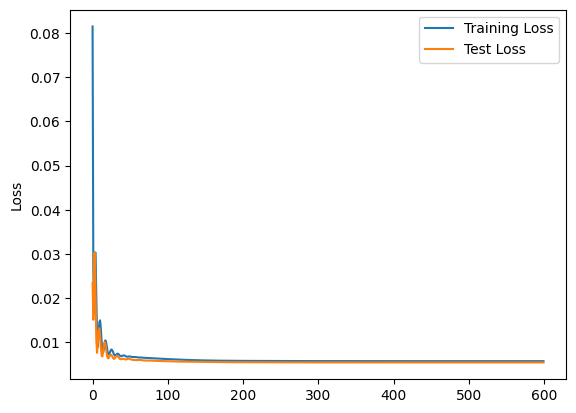

In [48]:
plot_loss()

In [49]:
count_params(model)

2369

Number of parameters = connections between layers + biases in every layyer

* input size = 72 (number of features)
* hidden layer size = 32
* output size = 1

count_params = (72*32 + 32*1) + (32 + 1):

In [50]:
72*32+32+32+1

2369

There are 2369 trainable parameters in the model

Evaluating the results:

In [51]:
results = add_eval(results, "SimpleNet", y_train, y_train_pred, y_test, y_test_pred)
results.sort_values(by='MAPE')

,algorithm,dataset,MSE,MAE,MAPE
5,SimpleNet,test,0.74495,0.86310,0.57108
3,LR_baseline,test,0.74494,0.86310,0.57113
4,SimpleNet,train,0.78620,0.88668,0.60343
2,LR_baseline,train,0.78620,0.88668,0.60351
1,Mean_baseline,test,1.92293,1.38670,0.94593
0,Mean_baseline,train,2.24988,1.49996,1.07217


The results of SimpleNet are identical with Linear Regression baseline. Our SimpleNet model reproduces a linear regression model. To improve the results we will add layers and activation function to the model architecture

### Multi Layer Perceptron 

More Sophisticated neural network with the ReLU activation function. 

The **Rectified Linear Unit (ReLU)** activation function is defined as ReLU(x) = max(0, x), where x is the input to the function. The simplicity of ReLU allows for efficient computation, making it well-suited for large-scale neural network architectures. 

ReLU introduces non-linearity to the neural network, allowing it to model complex relationships and learn non-linear mappings between inputs and outputs. Non-linear activation functions are crucial in enabling neural networks to approximate complex functions and capture intricate patterns in data.

ReLU helps alleviate the vanishing gradient problem, which can occur in deep neural networks during backpropagation. The vanishing gradient problem refers to the issue of gradients becoming very small as they propagate through multiple layers, resulting in slow or ineffective training. ReLU helps maintain non-zero gradients for positive inputs, which allows for effective gradient flow and faster convergence during training.

We will add ReLU activation function to our hidden layers

In [52]:
class MultiLayerPerceptron(nn.Module):

    def __init__(self, input_size):
        super(MultiLayerPerceptron, self).__init__()
        self.hidden_1 = nn.Linear(input_size, 128)
        self.hidden_2 = nn.Linear(128, 64)
        self.hidden_3 = nn.Linear(64, 32)
        self.output = nn.Linear(32,1)
       
 
    def forward(self, x):
        out1 = nn.ReLU()(self.hidden_1(x))
        out2 = nn.ReLU()(self.hidden_2(out1))
        out3 = nn.ReLU()(self.hidden_3(out2))
        
        return self.output(out3)

Set Hyperparameters of the learning process, train and test the model:

In [53]:
torch.manual_seed(42)
model=MultiLayerPerceptron(df_dummified.shape[1]) #number of features (columns) as input
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()
    y_train_pred = model(X_train_tensor)
    optimizer.zero_grad()
    train_loss = criterion(y_train_pred, y_train_tensor)
    train_loss.backward()
    optimizer.step()
    train_losses.append(train_loss.item())
    
    model.eval()
    with torch.no_grad():
        y_test_pred=model(X_test_tensor)
        test_loss = criterion(y_test_pred, y_test_tensor)
        y_train_pred=y_scaler.inverse_transform(y_train_pred)
        y_test_pred=y_scaler.inverse_transform(y_test_pred)  
    test_losses.append(test_loss.item())
    if (epoch % 100==99):
        print("Epoch: %d, train_loss: %1.5f, test_loss: %1.5F" % (epoch, train_loss.item(), test_loss.item()))

Epoch: 99, train_loss: 0.00094, test_loss: 0.00450
Epoch: 199, train_loss: 0.00048, test_loss: 0.00571
Epoch: 299, train_loss: 0.00042, test_loss: 0.00584
Epoch: 399, train_loss: 0.00034, test_loss: 0.00616
Epoch: 499, train_loss: 0.00030, test_loss: 0.00651
Epoch: 599, train_loss: 0.00029, test_loss: 0.00720


Plotting the results:

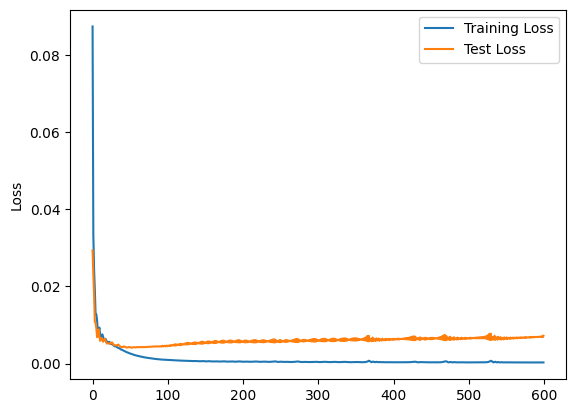

In [54]:
plot_loss()

In [55]:
count_params(model)

19713

Number of parameters - 19713, much more than before due to adding new layers with more neutrons

Number of parameters = connections between layers + biases in every layyer

* input size = 72 (number of features)
* hidden layers size = [128, 64, 32]
* output size = 1

count_params = (72*128 + 128*64 + 64*32 + 32*1) + (128 + 64 + 32 + 1):

In [56]:
(72*128 + 128*64 + 64*32 + 32*1) + (128 + 64 + 32 + 1)

19713

Evaluating the results:

In [57]:
results = add_eval(results, "MLP", y_train, y_train_pred, y_test, y_test_pred)
results.sort_values(by='MAPE')

,algorithm,dataset,MSE,MAE,MAPE
6,MLP,train,0.03987,0.19967,0.06825
7,MLP,test,0.98495,0.99245,0.44289
5,SimpleNet,test,0.74495,0.86310,0.57108
3,LR_baseline,test,0.74494,0.86310,0.57113
4,SimpleNet,train,0.78620,0.88668,0.60343
2,LR_baseline,train,0.78620,0.88668,0.60351
1,Mean_baseline,test,1.92293,1.38670,0.94593
0,Mean_baseline,train,2.24988,1.49996,1.07217


The MAPE result of the MLP model is better than that of SimpleNet. We also see a big difference between the metrics on training and testing data: low error values on training data, and much higher values of MSE, MAE and MAPE on unseen (testing) data. This is a sign of overfitting.

There are different ways to address the issue of overfitting in deep learning experiments:

* Overfitting can occur when the model learns to memorize the training data instead of generalizing well to unseen data. By increasing the amount of training data, you provide more diverse examples for the model to learn from, which can help mitigate overfitting. Apparently our dataset is not large enough for good training with generalization. However, there is no possibility to increase it at the moment due to the peculiarities of access to the information

* Data augmentation techniques involve applying random transformations to the training data, such as rotations, translations, or flips, to artificially increase the size and diversity of the training set. This technique rather does not fit our dataset

* Dropout. Dropout is a regularization technique where random neurons are temporarily dropped out during training. This prevents the model from relying too heavily on specific neurons and encourages the learning of more robust features. Our next step will be to add a new layer to the model architecture.

* Hyperparameter tuning: Optimize the hyperparameter of the dropout layer.

* Early stopping. Monitor the performance of the model on a validation set during training. If the validation loss starts to increase or the performance plateaus, stop the training early. This prevents the model from over-optimizing on the training data and potentially overfitting. Next, we will allocate a separate part of the dataset for validation

* Cross-validation. Perform cross-validation to get a better estimate of the model's performance. Cross-validation helps evaluate the model's generalization ability by training and evaluating the model on multiple subsets of the data. At the end we will check if it can provide a more reliable estimate of the model's performance and help detect overfitting. 

### Multi Layer Perceptron with Dropout Layer

Adding a dropout layer to the model. During training, randomly zeroes some of the elements of the input tensor with probability p using samples from a Bernoulli distribution. This has proven to be an effective technique for regularization and preventing the co-adaptation of neurons. By defalt the 'p' probability of an element to be zeroed is 0.5

In [58]:
class MLP_Dropout(nn.Module):

    def __init__(self, input_size):
        super(MLP_Dropout, self).__init__()
        self.hidden_1 = nn.Linear(input_size, 128)
        self.dropout_1 = nn.Dropout(0.5) #by default
        self.hidden_2 = nn.Linear(128, 64)
        self.hidden_3 = nn.Linear(64, 32)
        self.output = nn.Linear(32,1)
        
 
    def forward(self, x):        
        out1 = nn.ReLU()(self.hidden_1(x))
        out1 = self.dropout_1(out1)
        out2 = nn.ReLU()(self.hidden_2(out1))
        out3 = nn.ReLU()(self.hidden_3(out2))
        
        return self.output(out3)

Training and testing the model:

In [59]:
torch.manual_seed(42)
criterion = torch.nn.MSELoss()
learning_rate=0.01
epochs=600
model=MLP_Dropout(df_dummified.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()
    y_train_pred = model(X_train_tensor)
    optimizer.zero_grad()
    train_loss = criterion(y_train_pred, y_train_tensor)
    train_loss.backward()
    optimizer.step()
    train_losses.append(train_loss.item())
    
    model.eval()
    with torch.no_grad():
        y_test_pred=model(X_test_tensor)
        test_loss = criterion(y_test_pred, y_test_tensor)
        y_train_pred=y_scaler.inverse_transform(y_train_pred)
        y_test_pred=y_scaler.inverse_transform(y_test_pred)   
    test_losses.append(test_loss.item())
    if (epoch % 100==99):
        print("Epoch: %d, train_loss: %1.5f, test_loss: %1.5F" % (epoch, train_loss.item(), test_loss.item()))

Epoch: 99, train_loss: 0.00252, test_loss: 0.00382
Epoch: 199, train_loss: 0.00216, test_loss: 0.00389
Epoch: 299, train_loss: 0.00165, test_loss: 0.00363
Epoch: 399, train_loss: 0.00141, test_loss: 0.00365
Epoch: 499, train_loss: 0.00125, test_loss: 0.00384
Epoch: 599, train_loss: 0.00113, test_loss: 0.00399


When calling **model.eval()** on a model that includes dropout layers, it changes the mode of the dropout layers to evaluation mode. In evaluation mode, dropout layers behave differently compared to during training. During training, dropout layers randomly "drop out" units (set them to zero) with a specified probability, however during evaluation or testing, it is desirable to obtain consistent and deterministic results without randomness introduced by dropout. When model.eval() is called, dropout layers in the model are set to evaluation mode, which means that they no longer apply dropout and instead retain all units. This allows the model to produce consistent and deterministic outputs during inference or evaluation.

By switching to evaluation mode, the model ensures that the dropout layers do not introduce randomness or variability in the predictions. Instead, the model applies the learned weights and biases consistently to produce stable outputs. This is important when making predictions on new, unseen data, as it ensures that the model's behavior remains consistent and reliable.

Plotting the loss results for training and testing:

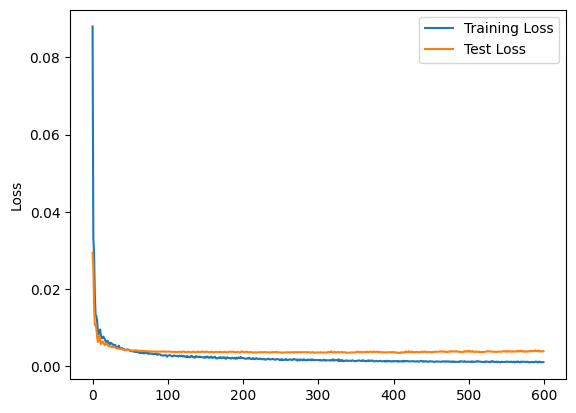

In [60]:
plot_loss()

The gap between training loss and testing loss has decreased, but is still present

In [61]:
count_params(model)

19713

Same number of parameters as before.

Evaluating the results:

In [62]:
results = add_eval(results, "MLP_Dropout", y_train, y_train_pred, y_test, y_test_pred)
results.sort_values(by='MAPE')

,algorithm,dataset,MSE,MAE,MAPE
6,MLP,train,0.03987,0.19967,0.06825
8,MLP_Dropout,train,0.15455,0.39313,0.24419
9,MLP_Dropout,test,0.54584,0.73881,0.38450
7,MLP,test,0.98495,0.99245,0.44289
5,SimpleNet,test,0.74495,0.86310,0.57108
3,LR_baseline,test,0.74494,0.86310,0.57113
4,SimpleNet,train,0.78620,0.88668,0.60343
2,LR_baseline,train,0.78620,0.88668,0.60351
1,Mean_baseline,test,1.92293,1.38670,0.94593
0,Mean_baseline,train,2.24988,1.49996,1.07217


The model with dropout layer shows the best result on test dataset. But still the difference between trainning and testing metrics is large - still the room for improvement.

### Split into Training, Validation and Test Data

Dividing data into train, validation, and test splits is a common practice in machine learning.

During the development process, we need to tune hyperparameters. The validation set allows us to evaluate and compare different hyperparameter choices without using the test set. This separation helps prevent overfitting to the test set and ensures that the final performance evaluation on the test set reflects the model's true generalization capability.

Overfitting occurs when a model becomes too specialized in fitting the training data and performs poorly on new data. The validation set helps detect overfitting by providing an independent dataset to evaluate the model's performance during training. It helps in monitoring the model's generalization performance and facilitates early stopping or other regularization techniques to prevent overfitting.

It's important to note that the specific proportions for the train-validation-test split may vary depending on the dataset size, complexity, and the available data. A common split is around 60-80% for training, 10-20% for validation, and 10-20% for testing. However, these percentages are not fixed and can be adjusted based on the specific requirements and constraints of your project.

However, by partitioning the available data into three sets, we drastically reduce the number of samples which can be used for learning the model, and the results can depend on a particular random choice for the pair of (train, validation) sets.

In [63]:
X_train_full, X_test, y_train_full, y_test = train_test_split(df_dummified, target, test_size=0.3, shuffle=True, random_state=42)

In [64]:
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1, shuffle=True, random_state=42)

In [65]:
for i in (X_train, X_val, X_test, y_train, y_val, y_test):
    print(i.shape)

(2718, 72)
(303, 72)
(1296, 72)
(2718, 1)
(303, 1)
(1296, 1)


By splitting the dataset we drastically decrease the number of instances in the training dataset.

**MinMaxScaler()** helps normalize the input data by scaling it to a specific range, typically between 0 and 1. Normalizing the data can help avoid issues related to different features having different scales, which can negatively impact the training process. Neural networks often perform better when the input features are on a similar scale, as it allows the model to converge more effectively.

In [66]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

Scaling the input data can contribute to more stable and efficient training of neural networks. Normalizing the data with MinMaxScaler() can help improve the generalization capability of the trained model. By scaling the input features to a specific range, it can reduce the influence of outliers and extreme values. 

In [67]:
x_scaler.fit(X_train_full)
X_train_sc = x_scaler.transform(X_train)
X_val_sc=x_scaler.transform(X_val)
X_test_sc = x_scaler.transform(X_test)

In [68]:
y_scaler.fit(y_train_full)
y_train_sc=y_scaler.transform(y_train)
y_val_sc=y_scaler.transform(y_val)
y_test_sc=y_scaler.transform(y_test)

Create Tensors for PyTorch

In [69]:
X_train_tensor=torch.Tensor(X_train_sc)
X_val_tensor=torch.Tensor(X_val_sc)
X_test_tensor=torch.Tensor(X_test_sc)
y_train_tensor=torch.Tensor(y_train_sc)
y_val_tensor=torch.Tensor(y_val_sc)
y_test_tensor=torch.Tensor(y_test_sc)

## Hyperparameter tuning 
Finding the best parameter for nn.Dropout layer of our MLP_Dropout model:

In [70]:
class MLP_Dropout(nn.Module):
    def __init__(self, input_size, dropout_prob):
        super(MLP_Dropout, self).__init__()

        self.hidden_1 = nn.Linear(input_size, 128)
        self.dropout_1 = nn.Dropout(dropout_prob)
        self.hidden_2 = nn.Linear(128, 64)
        self.hidden_3 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)

    def forward(self, x):
        out1 = nn.ReLU()(self.hidden_1(x))
        out1 = self.dropout_1(out1)
        out2 = nn.ReLU()(self.hidden_2(out1))
        out3 = nn.ReLU()(self.hidden_3(out2))
        return self.output(out3)

In [71]:
torch.manual_seed(42) #random seed for reproducability
learning_rate = 0.01
epochs = 600

dropout_params = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6] # dropout parameter values to search
best_mape = float('inf')
best_dropout_param = None

for dropout_prob in dropout_params: # hyperparameter search
    print(f"Testing dropout parameter: {dropout_prob}")

    model = MLP_Dropout(df_dummified.shape[1], dropout_prob)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        y_train_pred = model(X_train_tensor)
        optimizer.zero_grad()
        train_loss = criterion(y_train_pred, y_train_tensor)
        train_loss.backward()
        optimizer.step()
        train_losses.append(train_loss.item())

        model.eval()
        with torch.no_grad():
            y_val_pred = model(X_val_tensor)
            val_loss = criterion(y_val_pred, y_val_tensor)
            val_losses.append(val_loss.item())

    mape_val = mean_absolute_percentage_error(y_val, y_scaler.inverse_transform(y_val_pred))

    if mape_val < best_mape:     # check if this dropout parameter gives the best MAPE
        best_mape = mape_val
        best_dropout_param = dropout_prob

print(f"Best dropout parameter: {best_dropout_param}, Best MAPE: {best_mape}")

Testing dropout parameter: 0.1


Testing dropout parameter: 0.2
Testing dropout parameter: 0.3
Testing dropout parameter: 0.4
Testing dropout parameter: 0.5
Testing dropout parameter: 0.6
Best dropout parameter: 0.4, Best MAPE: 0.2662390935959234


The best result is MAPE = 0.2662 for dropout parameter 0.4 on the validation dataset

Finding the best model parameters for the **MLP_Dropout_best** model (with the best 'p' hypoparameter for dropout layer):

In [72]:
class MLP_Dropout_best(nn.Module):
    def __init__(self, input_size):
        super(MLP_Dropout_best, self).__init__()

        self.hidden_1 = nn.Linear(input_size, 128)
        self.dropout_1 = nn.Dropout(best_dropout_param) 
        self.hidden_2 = nn.Linear(128, 64)
        self.hidden_3 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)

    def forward(self, x):
        out1 = nn.ReLU()(self.hidden_1(x))
        out1 = self.dropout_1(out1)
        out2 = nn.ReLU()(self.hidden_2(out1))
        out3 = nn.ReLU()(self.hidden_3(out2))
        return self.output(out3)

We will train the model and track the best validation performance based on MAPE, save the model with the best performance:

In [73]:
torch.manual_seed(42) #random seed for reproducibility
learning_rate=0.01
criterion = torch.nn.MSELoss()
epochs=600
model_b=MLP_Dropout_best(df_dummified.shape[1])
optimizer = torch.optim.Adam(model_b.parameters(), lr=learning_rate)

best_mape_val=float('inf')
best_loss_val=float('inf')
best_model=copy.deepcopy(model_b.state_dict())
best_epoch=0
train_losses = []
val_losses = []

for epoch in range(epochs):
    
    model_b.train()
    y_train_pred = model_b(X_train_tensor) #a forward pass
    optimizer.zero_grad() #clear the gradients of the optimazer
    loss_train = criterion(y_train_pred, y_train_tensor) #calculate the training loss
    loss_train.backward() #backpropagate the gradients of the loss
    optimizer.step() #update the parameters based on the gradient

    model_b.eval() #set evaluation mode, desable dropout regularization
    with torch.no_grad(): #disable gradient computation 
        y_val_pred = model_b(X_val_tensor) #a forward pass with validation data
        loss_val=criterion(y_val_pred, y_val_tensor) #loss
        mape_train = mean_absolute_percentage_error(y_train, y_scaler.inverse_transform(y_train_pred))
        mape_val= mean_absolute_percentage_error(y_val, y_scaler.inverse_transform(y_val_pred))
        if mape_val< best_mape_val: 
            best_mape_val = mape_val
            best_loss_val=loss_val.item()
            best_model = copy.deepcopy(model_b.state_dict())
            best_epoch=epoch

    train_losses.append(loss_train.item())
    val_losses.append(loss_val.item())
    if (epoch % 100==99):
        print("Epoch: %d, train_loss: %1.5f, val_loss: %1.5F" % (epoch, loss_train.item(), loss_val.item()))


Epoch: 99, train_loss: 0.00254, val_loss: 0.00584
Epoch: 199, train_loss: 0.00177, val_loss: 0.00540
Epoch: 299, train_loss: 0.00144, val_loss: 0.00525
Epoch: 399, train_loss: 0.00113, val_loss: 0.00557
Epoch: 499, train_loss: 0.00097, val_loss: 0.00551
Epoch: 599, train_loss: 0.00091, val_loss: 0.00566


Plotting the training and validation loss:

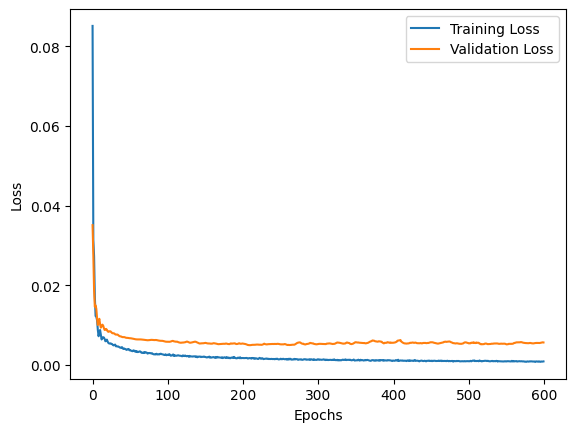

In [74]:
plt.plot(range(epochs), train_losses, label='Training Loss')
plt.plot(range(epochs), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The best epoch, best validation loss, and the best validation MAPE:

In [75]:
best_epoch, best_loss_val, best_mape_val

(556, 0.005338072311133146, 0.3089186622110441)

In [76]:
count_params(model_b)

19713

Still the same number of parameters

Now we will perform inference using a trained neural network model (model_b) with the best parameters (best_model)

Loading the saved state dictionary (best_model) into the model_b ensures that the model is restored to the state with the best validation performance achieved during training.

In [77]:
model_b.load_state_dict(best_model)
model_b.eval()
with torch.no_grad():
    y_train_pred=model_b(X_train_tensor)
    y_val_pred=model_b(X_val_tensor)
    y_test_pred = model_b(X_test_tensor)
    y_train_pred=y_scaler.inverse_transform(y_train_pred)
    y_val_pred=y_scaler.inverse_transform(y_val_pred)
    y_test_pred=y_scaler.inverse_transform(y_test_pred)


Now we have the predicted outputs (y_train_pred, y_val_pred, and y_test_pred) in their original scale, allowing to compare them directly with the original target values (y_train, y_val, and y_test) and analyze their performance.

Function for adding results into the table:

In [78]:
def add_eval_2(results, algorithm, y_train, y_train_pred, y_val, y_val_pred, y_test, y_test_pred):
    for dataset, actual, predicted in zip(
        ("train", "val", "test"), 
        (y_train, y_val, y_test), 
        (y_train_pred, y_val_pred, y_test_pred)):
        results= pd.concat([results, pd.DataFrame([{
            "algorithm": algorithm, 
            "dataset": dataset,
            "MSE": mean_squared_error(actual, predicted),
            "MAE": mean_squared_error(actual, predicted, squared=False),
            "MAPE": mean_absolute_percentage_error(actual, predicted)
        }])], ignore_index=True)   
    return results

Evaluation:

In [79]:
results = add_eval_2(results, "MLP_Dropout_best_w/h_val", y_train, y_train_pred, y_val, y_val_pred, y_test, y_test_pred)
results.sort_values(by='MAPE')

,algorithm,dataset,MSE,MAE,MAPE
6,MLP,train,0.039870,0.199670,0.068250
10,MLP_Dropout_best_w/h_val,train,0.098633,0.314059,0.194955
8,MLP_Dropout,train,0.154550,0.393130,0.244190
11,MLP_Dropout_best_w/h_val,val,0.730729,0.854827,0.308919
12,MLP_Dropout_best_w/h_val,test,0.548643,0.740705,0.362498
9,MLP_Dropout,test,0.545840,0.738810,0.384500
7,MLP,test,0.984950,0.992450,0.442890
5,SimpleNet,test,0.744950,0.863100,0.571080
3,LR_baseline,test,0.744940,0.863100,0.571130
4,SimpleNet,train,0.786200,0.886680,0.603430


In [80]:
results.sort_values(by='MAPE')

,algorithm,dataset,MSE,MAE,MAPE
6,MLP,train,0.039870,0.199670,0.068250
10,MLP_Dropout_best_w/h_val,train,0.098633,0.314059,0.194955
8,MLP_Dropout,train,0.154550,0.393130,0.244190
11,MLP_Dropout_best_w/h_val,val,0.730729,0.854827,0.308919
12,MLP_Dropout_best_w/h_val,test,0.548643,0.740705,0.362498
9,MLP_Dropout,test,0.545840,0.738810,0.384500
7,MLP,test,0.984950,0.992450,0.442890
5,SimpleNet,test,0.744950,0.863100,0.571080
3,LR_baseline,test,0.744940,0.863100,0.571130
4,SimpleNet,train,0.786200,0.886680,0.603430


MLP_Dropout_best model with validation split shows the best MAPE metrics at testing dataset. And the problem of overfitting still persists - we see that performance scores for the test data are not as good as for the training data. Also unclear influence of random, after all just one experiment complited and use only one (three-way) split.

## Cross-Validation

By partitioning the available data into three sets, we drastically reduce the number of samples which can be used for learning the model, and the results can depend on a particular random choice for the pair of (train, validation) sets.

A solution to this problem is a procedure called cross-validation (CV). A test set should still be held out for final evaluation, but the validation set is no longer needed when doing CV. In k-fold CV approach the training set is split into k smaller sets. The performance measure reported by k-fold cross-validation is then the average of the values computed in the loop.

In [81]:
X_train, X_test, y_train, y_test = train_test_split(df_dummified, target, test_size=0.4, shuffle=True, random_state=42)

X_train_tensor=torch.Tensor(x_scaler.fit_transform(X_train))
X_test_tensor=torch.Tensor(x_scaler.transform(X_test))
y_train_tensor=torch.Tensor(y_scaler.fit_transform(y_train))
y_test_tensor=torch.Tensor(y_scaler.transform(y_test))

We will implement a cross-validation loop that splits the training data into multiple folds. In each iteration of the loop, it will select the training and validation data for a specific fold and assign them to separate variables. These variables could then be used for training and evaluating the model on each fold of the cross-validation process.

Also we increase number the epochs to 1000

Epoch: 99, validation loss: 0.00053
Epoch: 199, validation loss: 0.00046
Epoch: 299, validation loss: 0.00045
Epoch: 399, validation loss: 0.00045
Epoch: 499, validation loss: 0.00041
Epoch: 599, validation loss: 0.00040
Epoch: 699, validation loss: 0.00042
Epoch: 799, validation loss: 0.00043
Epoch: 899, validation loss: 0.00040
Epoch: 999, validation loss: 0.00044


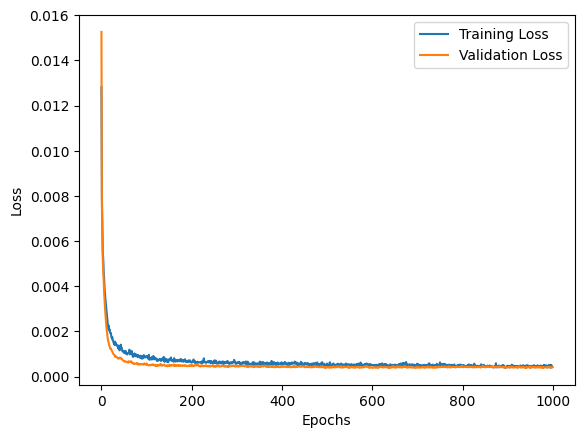

In [82]:
learning_rate = 0.01
criterion = nn.MSELoss()
epochs = 1000 #increase the number of epochs
model_b = MLP_Dropout_best(df_dummified.shape[1])
optimizer = optim.Adam(model_b.parameters(), lr=learning_rate)

num_folds = 5 # number of folds for cross-validation
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

train_losses = []
val_losses = []

best_val_loss = float('inf')
best_model_state = None

for epoch in range(epochs):
    total_loss = 0.0
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_tensor)): #iterates over each fold and obtains the indices of the training and validation data for the current fold.
        X_train_fold, X_val_fold = X_train_tensor[train_idx], X_train_tensor[val_idx] #fold-specific train and val datasets based on indices
        y_train_fold, y_val_fold = y_train_tensor[train_idx], y_train_tensor[val_idx]

        model_b.train()
        optimizer.zero_grad()

        y_train_pred = model_b(X_train_fold)
        train_loss = criterion(y_train_pred, y_train_fold)
        train_loss.backward()
        optimizer.step()

        model_b.eval()
        with torch.no_grad():
            y_val_pred = model_b(X_val_fold)
            val_loss = criterion(y_val_pred, y_val_fold)

        total_loss += val_loss.item()

    avg_val_loss = total_loss / num_folds #the average validation loss across all folds for the current epoch.
    train_losses.append(train_loss.item())
    val_losses.append(avg_val_loss)

    if avg_val_loss < best_val_loss: #if the current average validation loss is better than the previous best validation loss
        best_val_loss = avg_val_loss #updates the best validation loss
        best_model_state = model_b.state_dict().copy() #creates a copy of the model's state dictionary as the best model state

    if (epoch % 100 == 99):
        print("Epoch: %d, validation loss: %1.5f" % (epoch, avg_val_loss))

# Load the best model state
model_b.load_state_dict(best_model_state) #loading the state of the best model

# Use the best model to predict on test data
model_b.eval()
with torch.no_grad():
    y_train_pred=model_b(X_train_tensor)
    y_val_pred=model_b(X_val_tensor)
    y_test_pred = model_b(X_test_tensor)
    y_train_pred=y_scaler.inverse_transform(y_train_pred)
    y_val_pred=y_scaler.inverse_transform(y_val_pred)
    y_test_pred=y_scaler.inverse_transform(y_test_pred)

# Plot MSE during training
plt.plot(range(epochs), train_losses, label='Training Loss')
plt.plot(range(epochs), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


The code overall trains a neural network model using k-fold cross-validation, tracks the best model based on the average validation loss, and applies the best model to make predictions on the training, validation, and test data.

From the plot we can see that the loss graphs for training and validation data are close to each over 

In [83]:
results = add_eval_2(results, "MLP_Dropout_after_CV", y_train, y_train_pred, y_val, y_val_pred, y_test, y_test_pred)
results.sort_values(by='MAPE')

,algorithm,dataset,MSE,MAE,MAPE
6,MLP,train,0.039870,0.199670,0.068250
13,MLP_Dropout_after_CV,train,0.060975,0.246931,0.097620
14,MLP_Dropout_after_CV,val,0.065143,0.255232,0.106110
10,MLP_Dropout_best_w/h_val,train,0.098633,0.314059,0.194955
8,MLP_Dropout,train,0.154550,0.393130,0.244190
15,MLP_Dropout_after_CV,test,0.496497,0.704625,0.287380
11,MLP_Dropout_best_w/h_val,val,0.730729,0.854827,0.308919
12,MLP_Dropout_best_w/h_val,test,0.548643,0.740705,0.362498
9,MLP_Dropout,test,0.545840,0.738810,0.384500
7,MLP,test,0.984950,0.992450,0.442890


The MLP_Dropout model after cross-validation shows the best results on testing dataset.

* Training Performance: The MAPE of 0.097 for the training dataset indicates that, on average, the model's predictions have an absolute percentage error of approximately 9.7% compared to the actual values in the training data. This suggests that the model has performed relatively well on the training dataset.

* Validation Performance: The MAPE of 0.106 for the validation dataset indicates that, on average, the model's predictions have an absolute percentage error of around 10.6% compared to the actual values in the validation data. This indicates a slightly higher error compared to the training dataset, but it is still relatively low.

* Testing Performance: The MAPE of 0.287 for the testing dataset indicates that, on average, the model's predictions have an absolute percentage error of approximately 28.7% compared to the actual values in the testing data. This is higher than the MAPE values for both the training and validation datasets. It suggests that the model's performance is relatively worse on the unseen testing data compared to the training and validation datasets.

The model is performing well in terms of the MAPE on the training and validation datasets, indicating good predictive accuracy and generalization. However, there is a noticeable increase in the MAPE when it comes to the testing dataset, suggesting that the model may not perform as well on unseen data. 

It is possible for the results to depend on randomness, especially when there are elements of randomness involved in the training process. In our case, we are using the KFold function with the shuffle=True parameter, which introduces randomness in the splitting of the data into folds during cross-validation.

Randomness can influence the performance metrics, such as MSE, MAE, and MAPE, as the specific train-test splits or the order of the data points during training can have an impact on the model's learning process.

Using a fixed random seed helps in comparing and reproducing results, especially when evaluating different models or comparing the performance of a model with different hyperparameters or architectures. However, it's important to note that some randomness may still exist in the underlying training algorithms or in cases where external factors introduce randomness.

## Conclusion and Future Work

Achievements of the Work: We conducted experiments and developed a regression neural network model to predict interest rates on African government loans and bonds. The achieved results include the evaluation of various models and the identification of the MLP_Dropout model after cross-validation as the best performer on the testing dataset.

Interpretation of Results: The MLP_Dropout model after cross-validation demonstrated the best performance on the testing dataset, indicating its ability to make accurate predictions on unseen data. The MAPE values for the training and validation datasets were relatively low, suggesting good predictive accuracy and generalization. However, there was a noticeable increase in MAPE for the testing dataset, indicating that the model's performance on unseen data may not be as strong.

Comparison to the Original Plan: The original plan involved acquiring and preparing a dataset, conducting feature selection, developing regression neural network models with different architectures, and evaluating their performance. The achieved results align with the original plan, as various models were trained and evaluated using the dataset.

Generated Value: The developed regression neural network model provides valuable insights into predicting interest rates on African government loans and bonds. The model's predictions can aid policy-makers in making proactive decisions, help investors assess risk, and enable international organizations to develop targeted strategies for supporting economic development in African countries. By leveraging data-driven insights, GEA can contribute to the economic growth and stability of African nations.

Recommendations for the Organization: Based on the results, it is recommended to implement the MLP_Dropout model with cross-validation for predicting interest rates on African government loans and bonds. However, given the higher MAPE observed on the testing dataset, further fine-tuning and optimization of the model should be considered to improve its performance on unseen data. Additionally, continuous monitoring and updating of the model using new data would enhance its accuracy and reliability.

Ideas for Future Work:
* Dataset extension: Neural networks show the best results on really big data.
* Architecture modeling: Experiment with different architectures, to further enhance prediction accuracy and robustness.
* Futher Parametrization fine-tuning: While Adam is a commonly used and effective optimizer, SGD, RMSProp, or AdaGrad may yield better results. Despite these advantages, ReLU does have some limitations, several variants of ReLU, such as Leaky ReLU, Parametric ReLU, and Exponential Linear Units (ELUs), have been proposed to address the dying ReLU problem and improve upon ReLU's limitations. Different scaling techniques, such as standardization (e.g., StandardScaler()), may also be appropriate depending on the nature of the data.